## Prerequisites

In [369]:
# Data manipulation
import numpy as np
import pandas as pd
from datetime import datetime

# NLP
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import regex as re
import gensim
from gensim.utils import simple_preprocess
import spacy
from spacy import displacy
from spacy.tokens import Span
sp = spacy.load('en_core_web_sm')
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Machine learning
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
from itertools import combinations

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("paper")
#sns.set_style('darkgrid')
from sklearn.tree import plot_tree, export_text
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Miscellaneous
pd.set_option('display.float_format', lambda x:'{:.3f}'.format(x))
pd.set_option('max_columns', 40)
pd.set_option('max_colwidth', 99)

In [370]:
game_info = pd.read_csv('../Dataset/games_original.csv')
user_info = pd.read_csv('../Dataset/steam-200k.csv')

In [371]:
user_info.rename(columns={'151603712': 'userid', 'The Elder Scrolls V Skyrim': 'name', 'purchase': 'behavior', '1.0': 'hrs_played', '0': 'drop'}, inplace=True)

In [372]:
user_info.drop(columns=['drop'], inplace=True)

- **Missing Percentage**

In [373]:
game_info.isnull().sum().sort_values(ascending=False)[game_info.isnull().sum().sort_values(ascending=False)>0]/game_info.shape[0]*100

Publisher          100.000
DiscountedCost      97.883
Metacritic          88.076
Franchise           85.422
ESRB                84.187
RatingsBreakdown    42.916
Graphics            14.627
Genres              10.480
Storage              9.456
Memory               6.552
OriginalCost         1.835
Controller           1.151
Languages            1.083
Indie                0.961
Tags                 0.961
Soundtrack           0.961
Description          0.498
SteamURL             0.268
Platform             0.005
dtype: float64

- **Drop columns with more than 50% missing values.**
- **Drop RawgID, SteamURL, Unnamed: 0 which are not useful in our analysis.**

In [374]:
game_info.drop(columns=['Publisher', 'DiscountedCost', 'Metacritic', 'ESRB', 'Franchise', 'RatingsBreakdown', 
                        'Unnamed: 0', 'RawgID', 'SteamURL', 'appid'], inplace=True)

In [375]:
game_info.drop_duplicates(subset=['Name'], inplace=True)
game_info.reset_index(drop=True, inplace=True)
game_info.shape

(18470, 30)

In [376]:
game_info[['Genres','genres']].head(5)

,Genres,genres
0,"Action, Free to Play",Action;Free to Play
1,NaN,Action;Free to Play;Strategy
2,Action,Action
3,"Action, Adventure, Indie, Massively Multiplayer, RPG",Action;Adventure;Indie;Massively Multiplayer;RPG
4,"Action, Adventure",Action;Adventure


In [377]:
game_info.drop(columns=['Genres'], inplace=True)

In [378]:
# Platform and platforms contain information of different granularity. We will combine these two columns.
# But first, impute the missing values in Platform
game_info[['Platform', 'platforms']].head(5)

,Platform,platforms
0,"PC, Xbox 360, PlayStation 3",windows;mac;linux
1,"Linux, macOS, PC",windows;mac;linux
2,"PC, Nintendo Switch, Xbox One, PlayStation 4",windows
3,"Xbox One, macOS, PC, Linux",windows;mac
4,"PlayStation 5, PC, PlayStation 4, PlayStation 3, Xbox 360, Xbox One",windows


In [379]:
genres_index = list(game_info[game_info['Platform'].isnull()].index)
for index in genres_index:
    game_info.loc[index, 'Platform'] = game_info.loc[index, 'platforms']

In [380]:
# verified on steam, Tags column contains more accurate information. Therefore, we will drop steamspy_tags
game_info[['Tags', 'steamspy_tags']].head(5)

,Tags,steamspy_tags
0,"FPS, Shooter, Multiplayer, Competitive, Action, Team-Based, eSports, Tactical, First-Person, Pv...",FPS;Multiplayer;Shooter
1,"Free to Play, MOBA, Multiplayer, Strategy, eSports, Team-Based, Competitive, Action, Online Co-...",Free to Play;MOBA;Strategy
2,"Horror, Survival Horror, Multiplayer, Online Co-Op, Survival, Stealth, Gore, Blood, Third Perso...",Horror;Survival Horror;Multiplayer
3,"Survival, Crafting, Multiplayer, Open World, Open World Survival Craft, Building, Sandbox, PvP,...",Survival;Crafting;Multiplayer
4,"Open World, Action, Multiplayer, Automobile Sim, Crime, Third Person, First-Person, Shooter, Ad...",Open World;Action;Multiplayer


In [381]:
game_info.drop(columns=['steamspy_tags'], inplace=True)

In [382]:
# drop english column as information is contained in languages
game_info.drop(columns=['english'], inplace=True)

## Data Cleaning

### Impute Missing Values

In [383]:
# check missing value percentage
game_info.isnull().sum()[game_info.isnull().sum()>0].sort_values(ascending=False)/game_info.shape[0]*100

Graphics       13.817
Storage         8.560
Memory          5.393
OriginalCost    1.435
Description     0.509
Controller      0.081
Tags            0.011
Soundtrack      0.011
Indie           0.011
Languages       0.005
dtype: float64

In [384]:
cost_index = list(game_info[game_info['OriginalCost'].isnull()].index)
for index in cost_index:
    game_info.loc[index, 'OriginalCost']=0

In [385]:
controller_index = list(game_info[game_info['Controller'].isnull()].index)
for index in controller_index:
    game_info.loc[index, 'Controller']=0

In [386]:
music_index = list(game_info[game_info['Soundtrack'].isnull()].index)
for index in music_index:
    game_info.loc[index, 'Soundtrack']=0.0

In [387]:
Indie_index = list(game_info[game_info['Indie'].isnull()].index)
for index in Indie_index:
    game_info.loc[index, 'Indie']=0

In [388]:
language_index = list(game_info[game_info['Languages'].isnull()].index)
for index in language_index:
    game_info.loc[index, 'Languages']='English'

In [389]:
game_info.dropna(subset=['Tags', 'Description'], inplace=True)

- **Drop columns with more than 50% missing values.**
- **Drop RawgID, SteamURL, Unnamed: 0 which are not useful in our analysis.**

### Rename Columns

In [390]:
game_info.columns

Index(['id', 'Name', 'Indie', 'Presence', 'Platform', 'Graphics', 'Storage',
       'Memory', 'Soundtrack', 'OriginalCost', 'Controller', 'Languages',
       'Achievements', 'Description', 'Tags', 'release_date', 'developer',
       'publisher', 'platforms', 'required_age', 'categories', 'genres',
       'positive_ratings', 'negative_ratings', 'average_playtime',
       'median_playtime', 'owners'],
      dtype='object')

In [391]:
def cols_rename (df):
    df.columns = [x.lower() for x in df.columns]
    df.columns = [x.replace('id','rank').replace('originalcost','price').replace('positive_ratings','pos_ratings').replace('negative_ratings','neg_ratings').replace('average_playtime','avg_playtime') for x in df.columns]
    return df

In [392]:
game_info = cols_rename(game_info)

### Categorize Features

In [393]:
basic_info = ['name', 'indie', 'release_date', 'developer', 'publisher', 'description', 'price']
popularity = ['presence','soundtrack','pos_ratings','neg_ratings',
              'avg_playtime','median_playtime','owners', 'achievements']
requirements = ['platform', 'platforms', 'graphics', 'storage', 'memory', 'controller']
target_audience = ['languages', 'tags', 'categories', 'genres', 'required_age']

In [394]:
# check whether we missed out any columns, excluding our target variable ranking
len(basic_info)+len(popularity)+len(requirements)+len(target_audience)-len(game_info.columns)

-1

## Game Information

### Target Variable

- Using 'rank' as our proxy for game score (1-5), since we don't have score information. 
- Game score 5 means highest and game score 1 means lowest.

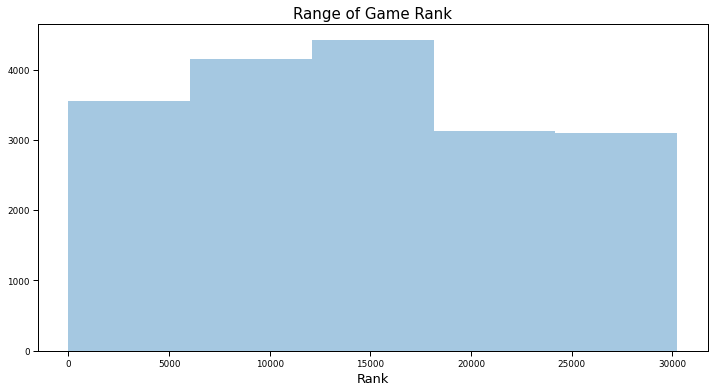

In [395]:
plt.figure(figsize=(12,6))
sns.distplot(game_info['rank'], bins=5, kde=False);
plt.title('Range of Game Rank', fontsize=15);
plt.xlabel('Rank', fontsize=13);

In [396]:
game_info['avg_score'] = game_info['rank'][::-1].values

In [397]:
bin_labels_5 = [1,2,3,4,5]
game_info['avg_score'] = pd.qcut(game_info['avg_score'], q=[0, 1/5, 2/5, 3/5, 4/5, 1], labels=bin_labels_5)

### Game Information

In [398]:
basic_info

['name',
 'indie',
 'release_date',
 'developer',
 'publisher',
 'description',
 'price']

#### Name

In [399]:
game_info['name_clean'] = game_info['name'].apply(lambda x: re.sub('\W+', ' ', x))

#### Indie

In [400]:
game_info['indie'].value_counts()

1.000    13928
0.000     4446
Name: indie, dtype: int64

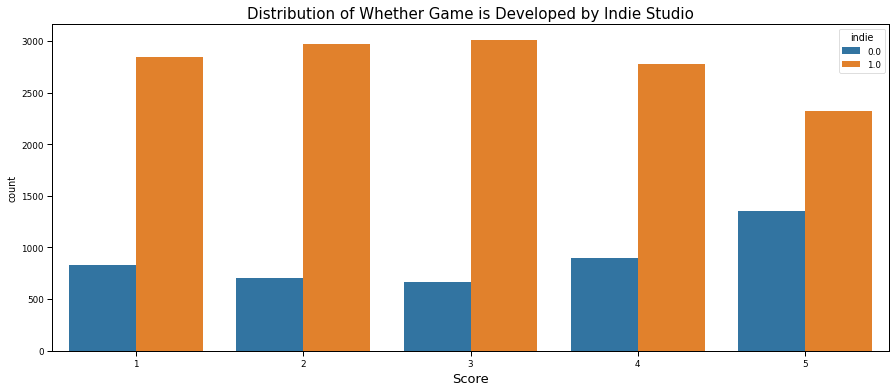

In [401]:
plt.figure(figsize=(15,6))
sns.countplot(x='avg_score', hue='indie', data=game_info);
plt.title('Distribution of Whether Game is Developed by Indie Studio', fontsize=15);
plt.xlabel('Score', fontsize=13);

- **Majority of games are developed by indie studio. Let's drop this column.**

In [402]:
game_info.drop(columns=['indie'], inplace=True)

#### Release Date

In [403]:
game_info['release_date'] = pd.to_datetime(game_info['release_date'])
game_info['year'] = pd.DatetimeIndex(game_info['release_date']).year
game_info['month'] = pd.DatetimeIndex(game_info['release_date']).month

In [404]:
game_info.drop(columns=['release_date'], inplace=True)

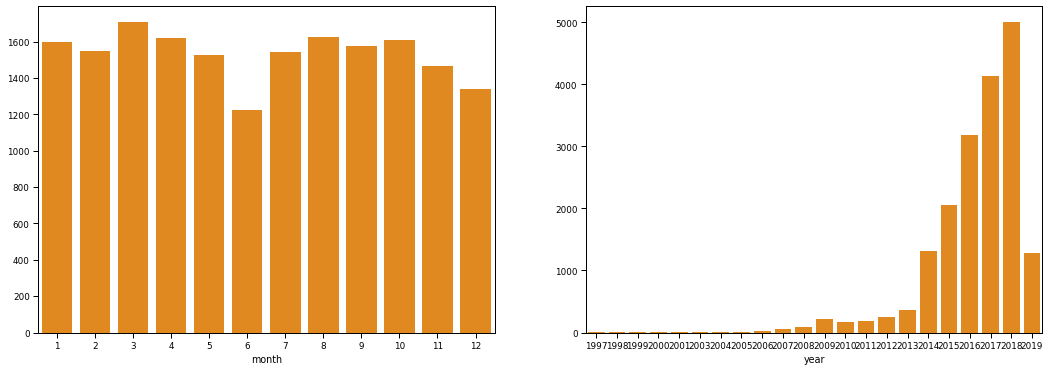

In [405]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
sns.barplot(x=game_info.groupby('month')['presence'].count().index, y=game_info.groupby('month')['presence'].count().values, ax=ax[0], color='darkorange');
sns.barplot(x=game_info.groupby('year')['presence'].count().index, y=game_info.groupby('year')['presence'].count().values, ax=ax[1], color='darkorange');

- Looks like there is a boom in the gaming industry from year 2014 onwards.

#### Developer and Publisher

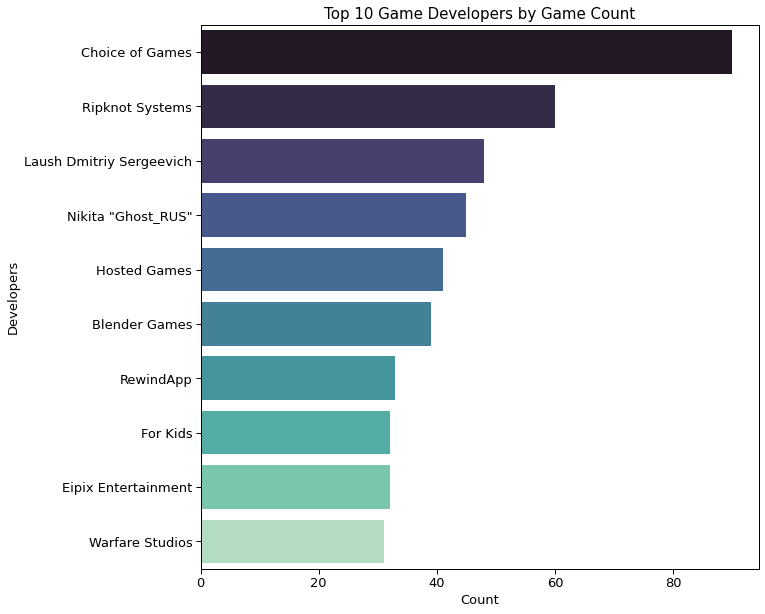

In [406]:
plt.figure(figsize=(10,10));
plt.title(f'Top 10 Game Developers by Game Count', fontsize=15);
sns.countplot(y="developer", data=game_info, order=game_info['developer'].value_counts().iloc[:10].index, palette='mako');
plt.ylabel('Developers', fontsize=13);
plt.xlabel('Count', fontsize=13);
plt.yticks(fontsize=13);
plt.xticks(fontsize=13);

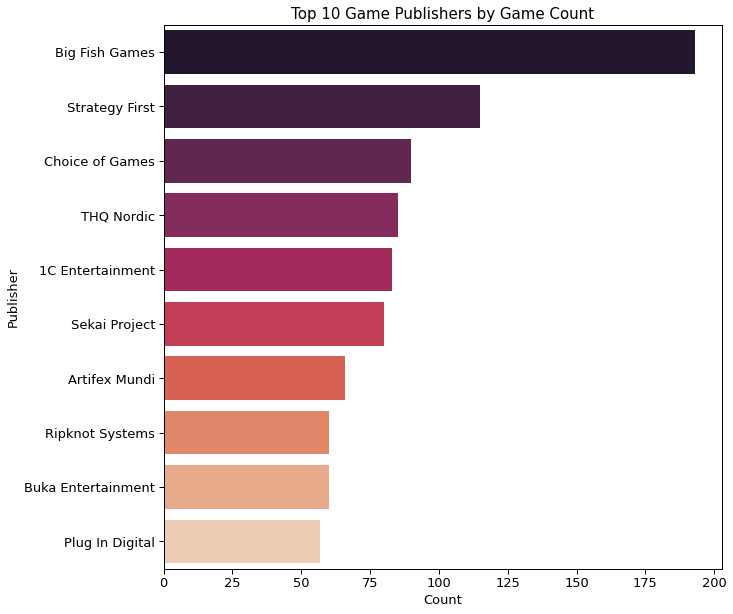

In [407]:
plt.figure(figsize=(10,10));
plt.title(f'Top 10 Game Publishers by Game Count', fontsize=15);
sns.countplot(y="publisher", data=game_info, order=game_info['publisher'].value_counts().iloc[:10].index, palette='rocket');
plt.ylabel('Publisher', fontsize=13);
plt.xlabel('Count', fontsize=13);
plt.yticks(fontsize=13);
plt.xticks(fontsize=13);

>Observations:
- 'Choice of games' and 'Ripknot Systems' are on both lists. They are top contributors as developer and publisher by game count.

In [408]:
game_info[game_info['avg_score']==5]['publisher'].value_counts()[:5]

THQ Nordic             45
Artifex Mundi          44
Square Enix            41
Devolver Digital       39
Paradox Interactive    36
Name: publisher, dtype: int64

In [409]:
game_info[game_info['avg_score']==4]['publisher'].value_counts()[:5]

Choice of Games     38
1C Entertainment    32
Sekai Project       29
THQ Nordic          26
Strategy First      23
Name: publisher, dtype: int64

In [410]:
game_info[game_info['avg_score']==3]['publisher'].value_counts()[:5]

Ripknot Systems       28
Buka Entertainment    25
1C Entertainment      23
Strategy First        22
For Kids              21
Name: publisher, dtype: int64

In [411]:
game_info[game_info['avg_score']==2]['publisher'].value_counts()[:5]

Big Fish Games    39
Strategy First    29
KISS ltd          28
RewindApp         24
Sometimes You     18
Name: publisher, dtype: int64

In [412]:
game_info[game_info['avg_score']==1]['publisher'].value_counts()[:5]

Big Fish Games     129
Strategy First      34
Choice of Games     24
HexWar Games        19
Laush Studio        18
Name: publisher, dtype: int64

In [413]:
game_info['developer'].value_counts()[:15]

Choice of Games             90
Ripknot Systems             60
Laush Dmitriy Sergeevich    48
Nikita "Ghost_RUS"          45
Hosted Games                41
Blender Games               39
RewindApp                   33
For Kids                    32
Eipix Entertainment         32
Warfare Studios             31
EnsenaSoft                  30
HexWar Games                26
MumboJumbo                  26
Creobit                     25
Humongous Entertainment     24
Name: developer, dtype: int64

In [414]:
game_info['publisher'].value_counts()[:15]

Big Fish Games        193
Strategy First        115
Choice of Games        90
THQ Nordic             85
1C Entertainment       83
Sekai Project          80
Artifex Mundi          66
Ripknot Systems        60
Buka Entertainment     60
Plug In Digital        57
Devolver Digital       56
AGM PLAYISM            56
Slitherine Ltd.        55
KISS ltd               53
Laush Studio           53
Name: publisher, dtype: int64

>- There is no relationship between the number of games a developer or publisher have and the quality of game. Greater number of games created or published does not imply quality games produced. 
- In our recommendation system, we will not include developer or publisher as our features, as it might introduce bias to certain developer or publisher if they have many games on the list. We should only recommend games base on quality and player interest. 

In [415]:
game_info.drop(columns=['developer', 'publisher'], inplace=True)

#### Game Description

In [416]:
stops = list(set(stopwords.words('english')))
games_sw = ['game','gameplay','play','player','players','world','new','level','time']
word_pos_tags = ['JJ','NN','NNP','NNS','VB','VBD','VBG','VBN','VBP','VBZ']
stops.extend(games_sw)

In [417]:
def text_processing(string):
    string = re.sub(r'\W+', ', ', string)
    string = re.sub(r'\d+', ', ', string)
    string = re.sub(r'[^\x01-\x7F]+', '', string) 
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(string.lower())
    tokens = [token for token in tokens if token not in stops]
    lemmatizer = WordNetLemmatizer()
    text_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # parts of speech tag
    text_tokens = nltk.pos_tag(text_tokens) 
    text_tokens = [word for word,tag in text_tokens if tag in word_pos_tags]
    text_tokens = ' '.join(text_tokens)
    if text_tokens =='':
        text_tokens = 'none'
    else:
        text_tokens = text_tokens
    return text_tokens

In [418]:
game_info['descr_clean'] = game_info['description'].apply(lambda x: text_processing(x))

In [419]:
cvec = CountVectorizer()
cvec.fit(game_info['descr_clean'])
bag_of_words = cvec.transform(game_info['descr_clean'])
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in cvec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [420]:
words_freq[:10]
# remove top frequent words
# ('world', 14692),
# ('new', 13229),
# ('level', 12696),
# ('time', 10600)

[('feature', 9488),
 ('mode', 9024),
 ('different', 8962),
 ('enemy', 8696),
 ('character', 7662),
 ('story', 7458),
 ('get', 7336),
 ('level', 7264),
 ('unique', 7215),
 ('take', 7089)]

In [421]:
game_descr_list = game_info['descr_clean'].values.tolist()

In [422]:
game_descr = ','.join(game_descr_list)

In [423]:
def plot_cloud(doc_path, words, name):
    char_mask = np.array(Image.open(doc_path))
    image_colors = ImageColorGenerator(char_mask)
    wordcloud = WordCloud(width = 4000, height = 3000, random_state=1, background_color='black', colormap='Pastel1', 
                          collocations=False, stopwords = stops, mask=char_mask).generate(words)
    plt.figure(figsize=(18, 14)) # Set figure size    
    plt.imshow(wordcloud) # Display image    
    plt.axis("off"); # No axis details
    plt.title(f'Key Words from - {name}', fontsize=20)

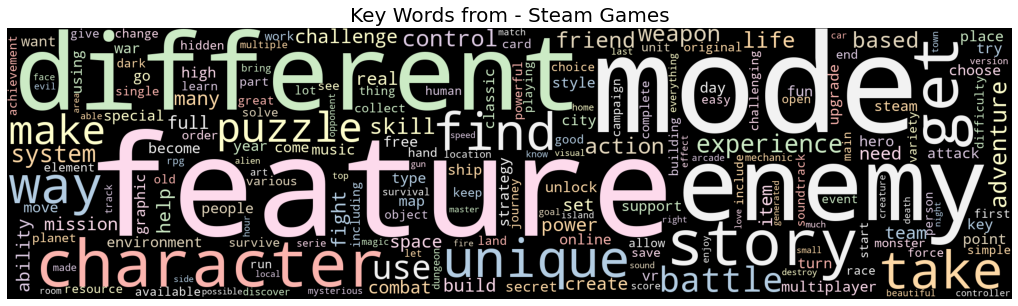

In [424]:
plot_cloud("../Dataset/wow.png", game_descr, 'Steam Games')

>- Looks like majority of the games are puzzle, adventure and action games. Most games are telling users they are providing many features and characters to provide different player experience as compared to other games. 

#### Price

In [425]:
def strip_number(string):
    try:
        return float(string.replace('$', ''))
    except ValueError:
        return 0
    except AttributeError:
        return string

In [426]:
game_info['price'] = game_info['price'].apply(lambda x: strip_number(x))

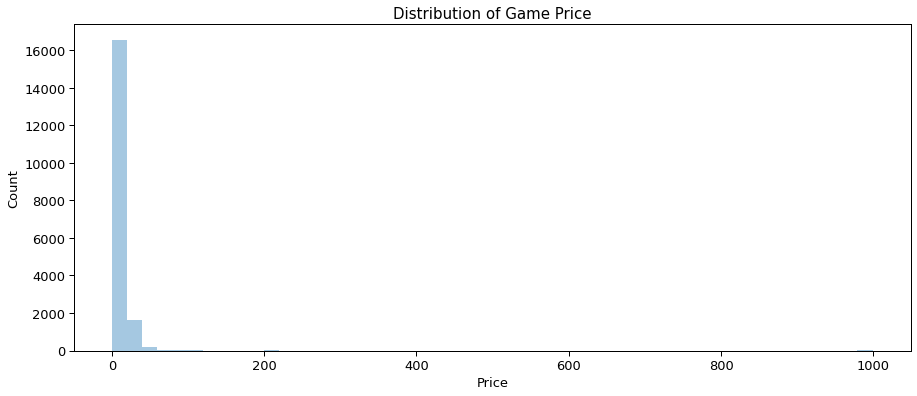

In [427]:
plt.figure(figsize=(15,6));
sns.distplot(game_info['price'], kde=False);
plt.title(f'Distribution of Game Price', fontsize=15);
plt.ylabel('Count', fontsize=13);
plt.xlabel('Price', fontsize=13);
plt.yticks(fontsize=13);
plt.xticks(fontsize=13);

In [428]:
game_info[game_info['price']>200]

,rank,name,presence,platform,graphics,storage,memory,soundtrack,price,controller,languages,achievements,description,tags,platforms,required_age,categories,genres,pos_ratings,neg_ratings,avg_playtime,median_playtime,owners,avg_score,name_clean,year,month,descr_clean
14020,21376,Rexodus: A VR Story Experience,401,PC,Nvidia 1060 GPU,5 GB available space,8 GB RAM,0.000,999.000,1.000,English,0,Rexodus: A VR Story Experience is based on the Dark Horse Graphic Novel Rexodus. This is a VR n...,"Action, VR, Zombies, Multiplayer, Arena Shooter",windows,0,Single-player;Partial Controller Support,Casual;Free to Play;Indie,72,28,0,0,50000-100000,2,Rexodus A VR Story Experience,2016,8,rexodus vr story experience based dark horse graphic novel rexodus vr narrative experience set ...


- Verified from website, this is actually a free game. 

In [429]:
game_info.loc[14020, 'price']=0

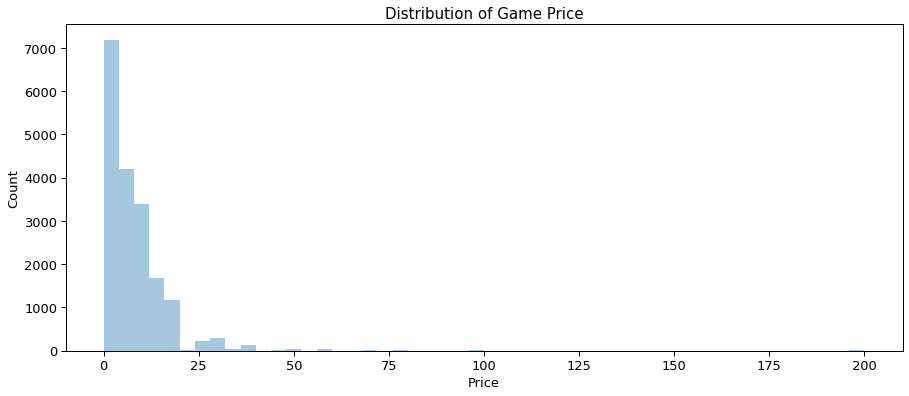

In [430]:
plt.figure(figsize=(15,6));
sns.distplot(game_info['price'], kde=False);
plt.title(f'Distribution of Game Price', fontsize=15);
plt.ylabel('Count', fontsize=13);
plt.xlabel('Price', fontsize=13);
plt.yticks(fontsize=13);
plt.xticks(fontsize=13);

> Observations:
- Majority of the games are within 50 dollars, however, there are a few expensive games in our analysis. 
- There are some games which are really expensive, which makes distribution of game price much right skewed. 
- Let's drop these outliers which are more than 60 dollars. 

In [431]:
to_drop = game_info[game_info['price']>60].index

In [432]:
game_info.drop(index=to_drop, inplace=True)

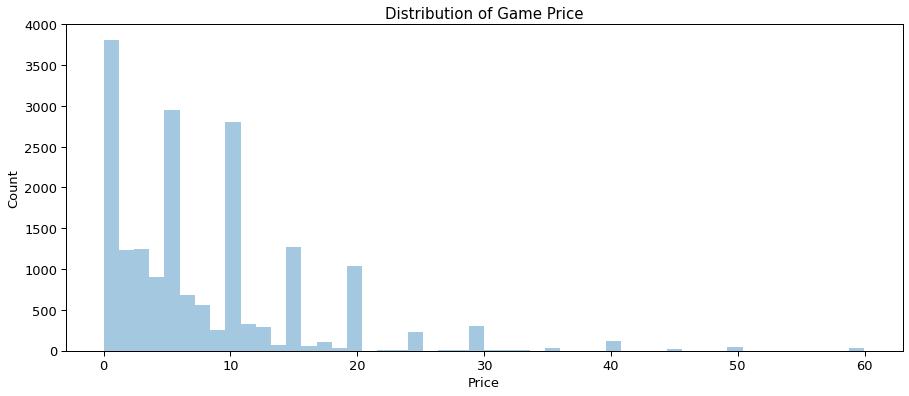

In [433]:
plt.figure(figsize=(15,6));
sns.distplot(game_info['price'], kde=False);
plt.title(f'Distribution of Game Price', fontsize=15);
plt.ylabel('Count', fontsize=13);
plt.xlabel('Price', fontsize=13);
plt.yticks(fontsize=13);
plt.xticks(fontsize=13);

In [589]:
price_df = game_info[['avg_score', 'price']]

In [590]:
price_df['free'] = price_df['price'].apply(lambda x: 0 if x==0.0 else 1)

<ipython-input-590-fb7dc136641d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['free'] = price_df['price'].apply(lambda x: 0 if x==0.0 else 1)


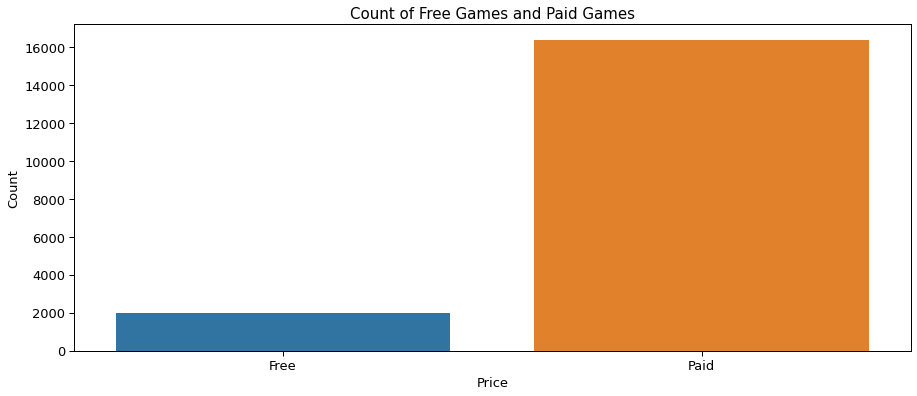

In [591]:
plt.figure(figsize=(15,6))
sns.countplot(x='free', data=price_df);
plt.title(f'Count of Free Games and Paid Games', fontsize=15);
plt.ylabel('Count', fontsize=13);
plt.xlabel('Price', fontsize=13);
plt.yticks(fontsize=13);
plt.xticks(np.arange(2), ['Free', 'Paid'], fontsize=13);

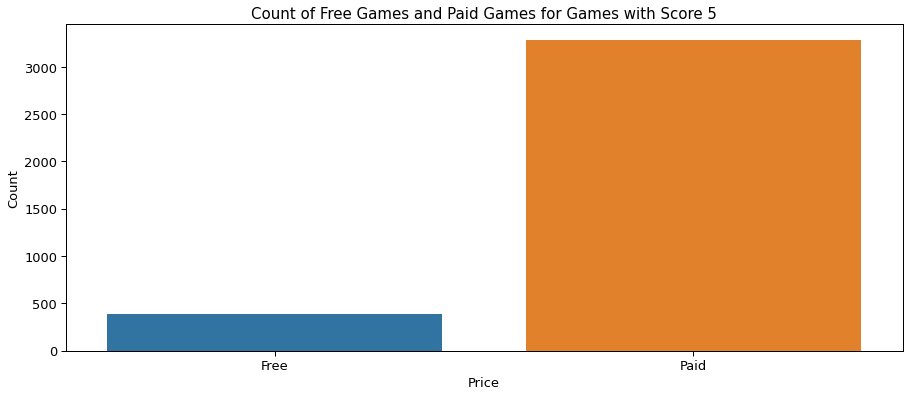

In [595]:
plt.figure(figsize=(15,6))
sns.countplot(x='free', data=price_df[price_df['avg_score']==5]);
plt.title(f'Count of Free Games and Paid Games for Games with Score 5', fontsize=15);
plt.ylabel('Count', fontsize=13);
plt.xlabel('Price', fontsize=13);
plt.yticks(fontsize=13);
plt.xticks(np.arange(2), ['Free', 'Paid'], fontsize=13);

### Popularity

In [434]:
popularity

['presence',
 'soundtrack',
 'pos_ratings',
 'neg_ratings',
 'avg_playtime',
 'median_playtime',
 'owners',
 'achievements']

#### Presence

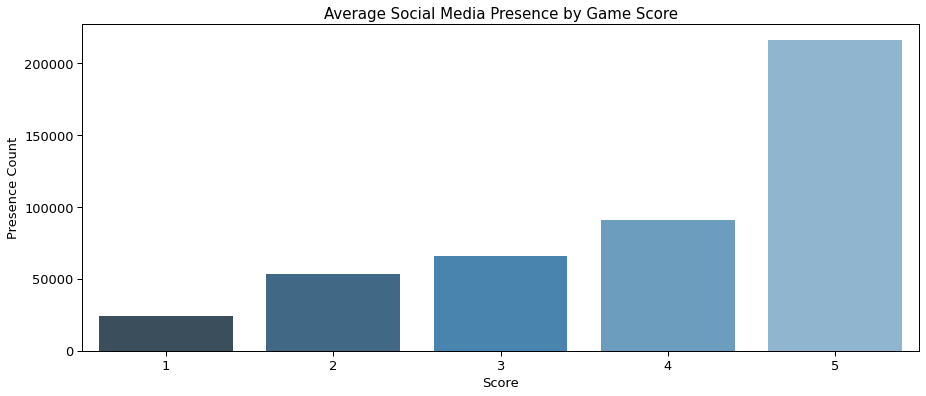

In [435]:
plt.figure(figsize=(15,6))
sns.barplot(x=game_info.groupby('avg_score')['presence'].mean().index, y=game_info.groupby('avg_score')['presence'].mean().values, palette='Blues_d');
plt.title(f'Average Social Media Presence by Game Score', fontsize=15);
plt.ylabel('Presence Count', fontsize=13);
plt.xlabel('Score', fontsize=13);
plt.yticks(fontsize=13);
plt.xticks(fontsize=13);

>Observations:
- It is observed that the higher the game is ranked, the bigger its social media footprint is. 
- This makes complete sense as good games will have more players and more discussions in the on-line forum and social media platforms. 

#### Soundtrack

In [436]:
game_info['soundtrack'].value_counts(normalize=True)

0.000   0.996
1.000   0.004
Name: soundtrack, dtype: float64

- **Only 0.4% of the games are well known for their soundtrack. We will drop this feature.**

In [437]:
game_info.drop(columns=['soundtrack'], inplace=True)

#### Ratings

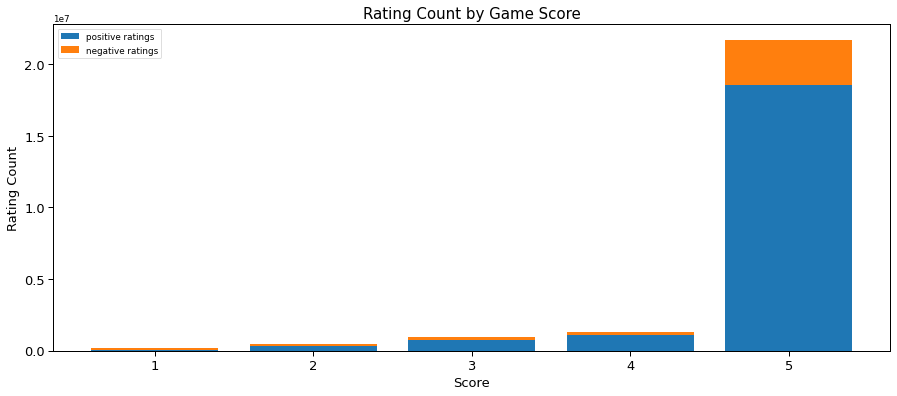

In [438]:
# Create brown bars
plt.figure(figsize=(15,6))
Score = [1,2,3,4,5]
plt.bar(Score, game_info.groupby('avg_score')['pos_ratings'].sum(), label='positive ratings')
# Create green bars (middle), on top of the firs ones
plt.bar(Score, game_info.groupby('avg_score')['neg_ratings'].sum(), bottom=game_info.groupby('avg_score')['pos_ratings'].sum(), label='negative ratings')
# Custom X axis
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Score", fontsize=13)
plt.ylabel("Rating Count", fontsize=13)
plt.title('Rating Count by Game Score', fontsize=15)
# Show graphic
plt.legend()
plt.show()

In [439]:
game_info['pos_ratings'] = game_info['pos_ratings']+1
game_info['neg_ratings'] = game_info['neg_ratings']+1

In [440]:
game_info['pos_rating_pct'] = game_info['pos_ratings']/game_info['neg_ratings']

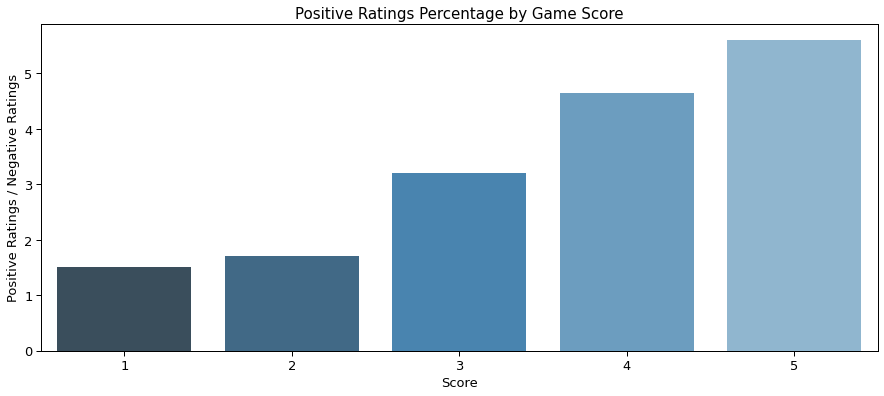

In [577]:
plt.figure(figsize=(15,6))
sns.barplot(x=game_info.groupby('avg_score')['pos_rating_pct'].median().index, y=game_info.groupby('avg_score')['pos_rating_pct'].median().values, palette='Blues_d');
plt.title(f'Positive Ratings Percentage by Game Score', fontsize=15);
plt.ylabel('Positive Ratings / Negative Ratings', fontsize=13);
plt.xlabel('Score', fontsize=13);
plt.yticks(fontsize=13);
plt.xticks(fontsize=13);

>Observations:
- It is observed that when a game is top ranked on leader board, it has more reviews including both positive and negative ratings as compared to other tiers. 
- In terms of positive review percentage, it increases as the game gets more popular. It is observed that from score 2 to 5, the good review percentage has a positive correlation with game score. 
- An exception is observed for games with score 1. These games usually have limited reviews and some are possibly from the development team or publisher themselves. Therefore, there might be bias in these reviews and hence it is higher than games with score 2. 
- We won't include negative ratings in our recommendation, because we are predicting how well the user will like a given game and not how much the user will hate a given game.

In [442]:
game_info.drop(columns=['neg_ratings'], inplace=True)

#### Playtime

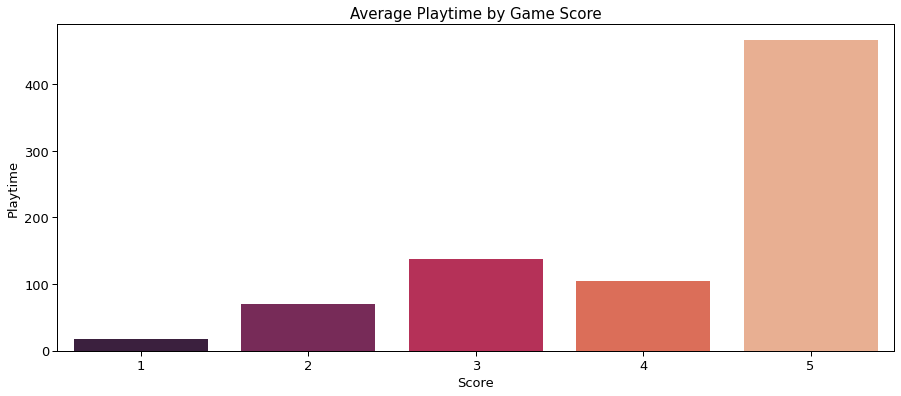

In [443]:
plt.figure(figsize=(15,6))
sns.barplot(x=game_info.groupby('avg_score')['avg_playtime'].mean().index, y=game_info.groupby('avg_score')['avg_playtime'].mean().values, palette='rocket'
    );
plt.title(f'Average Playtime by Game Score', fontsize=15);
plt.ylabel('Playtime', fontsize=13);
plt.xlabel('Score', fontsize=13);
plt.yticks(fontsize=13);
plt.xticks(fontsize=13);

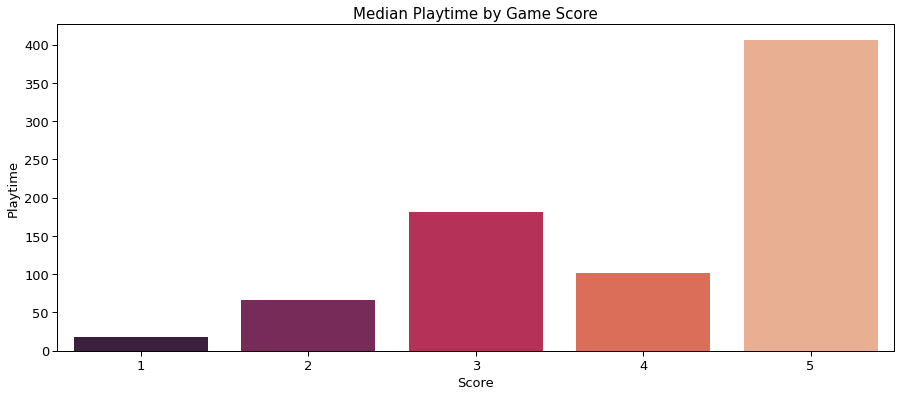

In [444]:
plt.figure(figsize=(15,6))
sns.barplot(x=game_info.groupby('avg_score')['median_playtime'].mean().index, y=game_info.groupby('avg_score')['median_playtime'].mean().values, palette='rocket');
plt.title(f'Median Playtime by Game Score', fontsize=15);
plt.ylabel('Playtime', fontsize=13);
plt.xlabel('Score', fontsize=13);
plt.yticks(fontsize=13);
plt.xticks(fontsize=13);

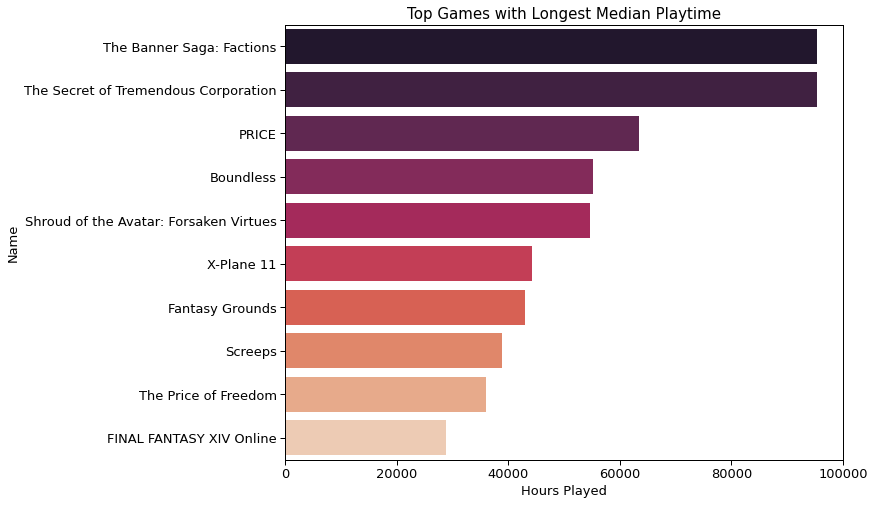

In [445]:
plt.figure(figsize=(10,8))
sns.barplot(y='name', x='avg_playtime', data=game_info[game_info['avg_playtime']>28000].sort_values(by='avg_playtime',ascending=False),palette='rocket');
plt.title(f'Top Games with Longest Median Playtime', fontsize=15);
plt.ylabel('Name',fontsize=13);
plt.xlabel('Hours Played', fontsize=13);
plt.yticks(fontsize=13);
plt.xticks(fontsize=13);

>Observations:
- It is observed that average and median time has positive correlation with game score with exception of games with score 4. 
- This could due to the following reasons:
    - playtime information is missing from some games, causing a lower average play time from the true average play time
    - games with score 4 could be games with shorter play time as compared to other games. 

#### Owners

In [446]:
def cal_mean_owner (string):
    owner = 0
    string = string.split('-')
    for i in string:
        owner += float(i)
    return owner

In [447]:
game_info['owners'] = game_info['owners'].apply(lambda x: cal_mean_owner(x))

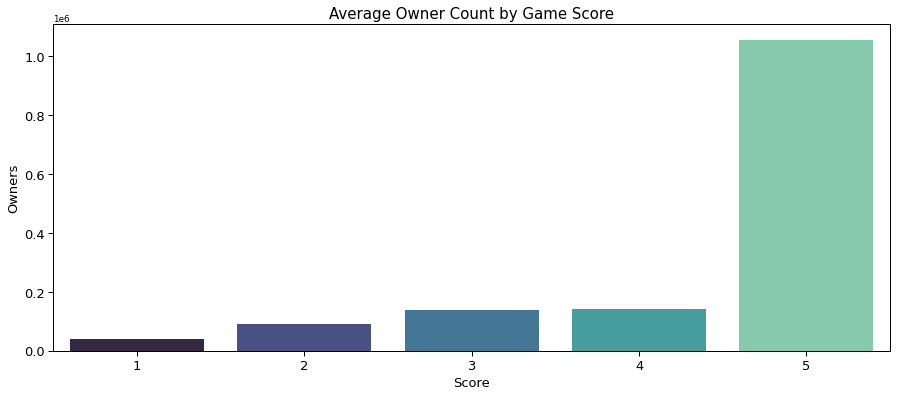

In [448]:
plt.figure(figsize=(15,6))
sns.barplot(x=game_info.groupby('avg_score')['owners'].mean().index, y=game_info.groupby('avg_score')['owners'].mean().values, palette='mako');
plt.title(f'Average Owner Count by Game Score', fontsize=15);
plt.ylabel('Owners', fontsize=13);
plt.xlabel('Score', fontsize=13);
plt.yticks(fontsize=13);
plt.xticks(fontsize=13);

>Observations:
- Number of owners generally shows positive relationship with game scores. 
- Games with score 5 has significantly larger average number of owners as compare to games with lower scores. 

#### Achievements

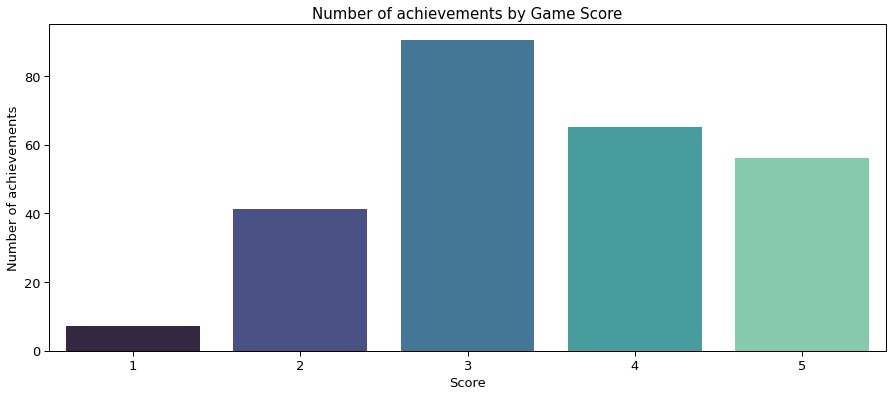

In [449]:
plt.figure(figsize=(15,6))
sns.barplot(x=game_info.groupby('avg_score')['achievements'].mean().index, y=game_info.groupby('avg_score')['achievements'].mean().values, palette='mako');
plt.title(f'Number of achievements by Game Score', fontsize=15);
plt.ylabel('Number of achievements', fontsize=13);
plt.xlabel('Score', fontsize=13);
plt.yticks(fontsize=13);
plt.xticks(fontsize=13);

In [450]:
game_info.drop(columns=['achievements'], inplace=True)

- It is observed that as number of achievements increases, game score decreases from 5 to 3. When number of achievements increases, games get more difficult to continue playing. Some players might drop out because of difficulty and leave lower scores. The other possible reason is that when the number of achievements increases, players need to purchase power-ups and add-ons to pass get certain achievements, leading to lower player experience and therefore, lower game score.
- It is also observed that for games with score of 2 and 1, the number of achievements are less than other games. This could be the reason that either these achievements are too simple or the games themselves are too simple which lead to player churn and lower game score. 

### System Requirements

In [451]:
requirements

['platform', 'platforms', 'graphics', 'storage', 'memory', 'controller']

#### Platforms

In [452]:
game_info[['platform', 'platforms']].head(3)

,platform,platforms
0,"PC, Xbox 360, PlayStation 3",windows;mac;linux
1,"Linux, macOS, PC",windows;mac;linux
2,"PC, Nintendo Switch, Xbox One, PlayStation 4",windows


In [453]:
game_info['platforms'] = game_info['platform']+','+game_info['platforms']

In [454]:
game_info.drop(columns=['platform'], inplace=True)

In [455]:
def extract_platform (strings):
    strings = strings.lower().replace(';', ' ,').replace('macOS', 'mac').replace('pc,', '')
    strings = set([i.strip() for i in strings.split(',')])
    strings = list(strings)
    return strings

In [456]:
game_info['platforms'] = game_info['platforms'].apply(lambda x: extract_platform(x))

In [457]:
game_info['platform_num'] = game_info['platforms'].apply(lambda x: len(x))

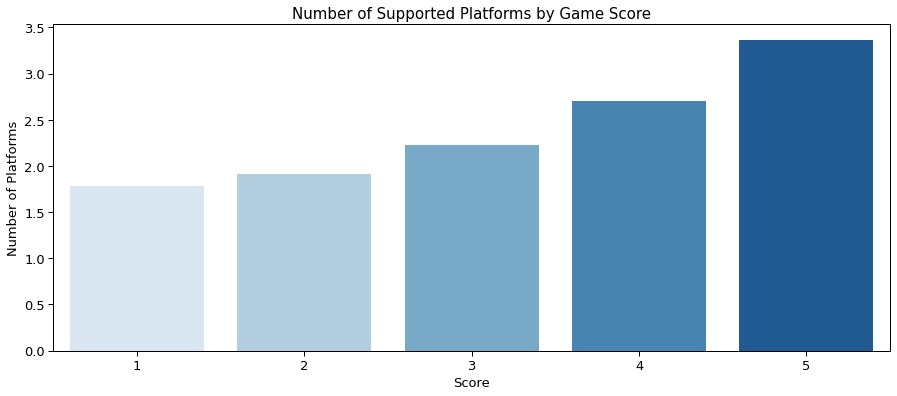

In [458]:
plt.figure(figsize=(15,6))
sns.barplot(x=game_info.groupby('avg_score')['platform_num'].mean().index, y=game_info.groupby('avg_score')['platform_num'].mean().values, palette='Blues');
plt.title(f'Number of Supported Platforms by Game Score', fontsize=15);
plt.ylabel('Number of Platforms', fontsize=13);
plt.xlabel('Score', fontsize=13);
plt.yticks(fontsize=13);
plt.xticks(fontsize=13);

In [459]:
def find_platform(platform_list):
    result = []
    for i in platform_list:
        result.append(i.split(' ')[0])
    return list(set(result))

In [460]:
game_info['platforms'] = game_info['platforms'].apply(lambda x: find_platform(x))

In [461]:
def unique_platform(platform_list):
    platform_list = ' '.join(platform_list)
    platform_list = platform_list.replace('windows', 'pc').replace('macos', 'pc').replace('mac', 'pc').replace('linux', 'pc').replace('ios', 'mobile').replace('android', 'mobile').replace('psp', 'playstation').replace('ps', 'playstation')
    platform_list = platform_list.split(' ')
    return list(set(platform_list))

In [462]:
game_info['platforms'] = game_info['platforms'].apply(lambda x: unique_platform(x))

In [463]:
unique_platforms = ['pc', 'playstation', 'xbox', 'nintendo', 'mobile', 'wii']
for platform in unique_platforms:
    game_info['platform_' + platform] = game_info['platforms'].map(lambda x: 1 if platform in x else 0)

>Observations:
- It is observed that the better the game is, the more platforms the game supports. 
- This could also be the reason 

#### Graphics

In [464]:
graphics_index = game_info[-game_info['graphics'].isnull()].index

In [465]:
game_info['graphics_num']=0

In [466]:
def text_cleaning(string):  
    graphics_card = []
    num = 0

    # Entity Resolution
    string = string.lower()
    string = string.replace('nvidia', 'Nvidia').replace('geforce', 'Nvidia').replace('gtx', 'Nvidia').replace('radeon', 'AMD').replace('intel', 'Intel')
    string = re.sub(r'\W', ', ', string)    
    string = sp(string)
    for entity in string.ents:
        if entity.label_=='ORG':
            graphics_card.append(entity.text)
    num = len(list(set(graphics_card)))
    # If num=0 means the game does not restrict a specific graphic card
    # If num=3 restrict it to 3 (Intel, AMD and Nvidia only)
    if num not in [1,2,3]:
        num=3
    else:
        num=num
    return num

In [467]:
for i in graphics_index:
    game_info.loc[i, 'graphics_num'] = text_cleaning(game_info.loc[i, 'graphics'])

<ipython-input-468-15f22a053eae>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.distplot(game_info[-game_info['graphics'].isnull()][(game_info['avg_score']==(i+1))]['graphics_num'], kde=False, ax=ax[i]);


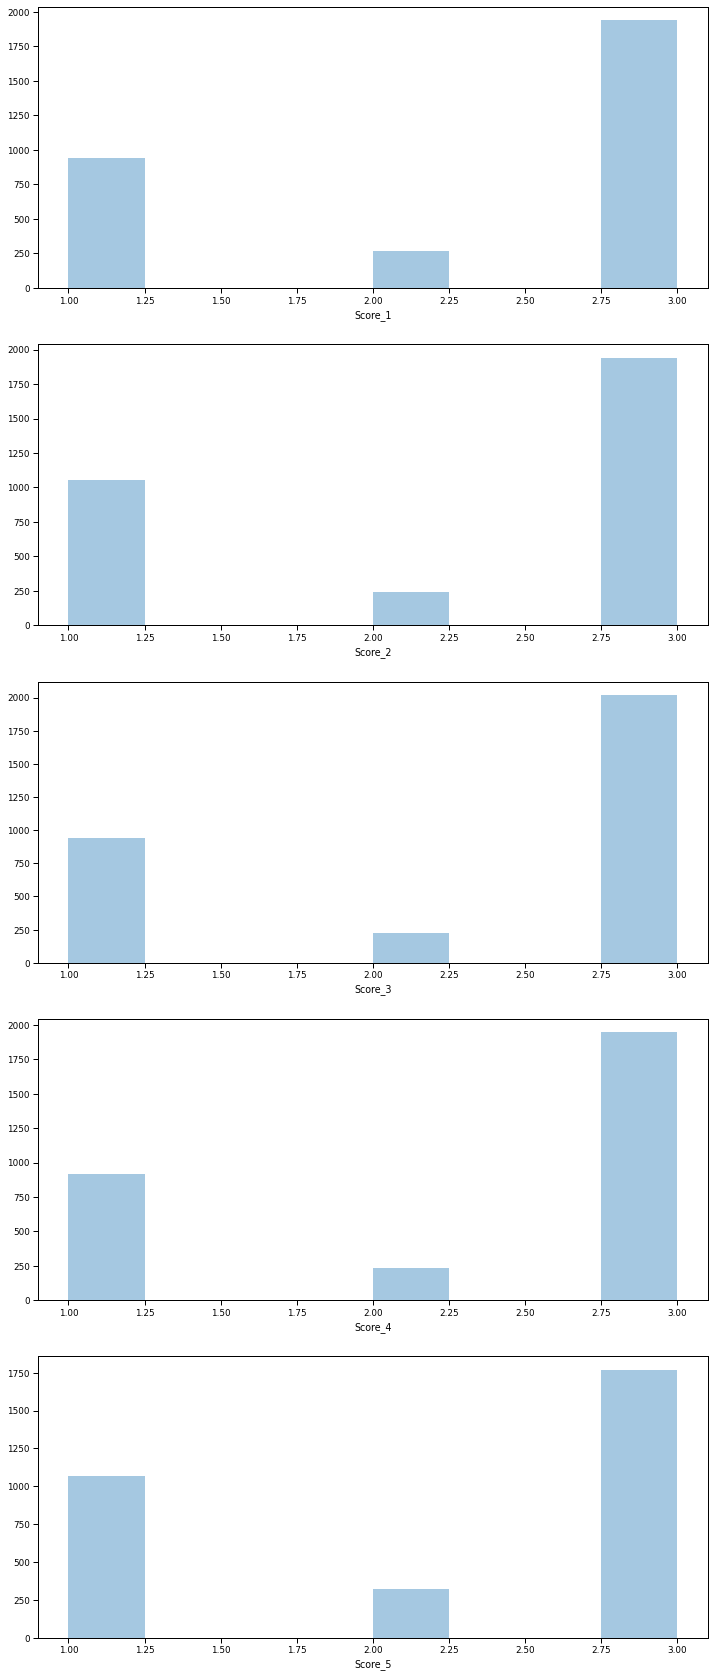

In [468]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize = (12,30))
for i in range(5):
    sns.distplot(game_info[-game_info['graphics'].isnull()][(game_info['avg_score']==(i+1))]['graphics_num'], kde=False, ax=ax[i]);
    ax[i].set_xlabel(f'Score_{i+1}')

In [469]:
game_info.drop(columns=['graphics', 'graphics_num'], inplace=True)

>Observations:
- It is observed that distribution of required graphics card types are the same cross games with different ratings. 
- Type of graphics card used has no clear relationship with how the game is rated. 

#### Memory and Storage

In [470]:
def size_conversion(string):
    size=0
    string = string.lower()
    # to account for special occurance: 512+MB of RAM
    string = string.replace('+', '')
    try: 
        string =  re.findall(r'(\d*(.)(\d*)([\s|])*(g|m))', string)[0][0]
    except IndexError:
        size = 0
        
    try:
        if 'g' in string:
            size = float(string.split('g')[0])
        elif 'm' in string:
            size = float(string.split('m')[0])/1024
        else:
            size = 0
    except ValueError:
        size = 0
    
    return size

In [471]:
memory_null = list(game_info[game_info['memory'].isnull()].index)
storage_null = list(game_info[game_info['storage'].isnull()].index)

In [472]:
null_value = '0 GB RAM'

In [473]:
game_info['memory'] = game_info['memory'].fillna(null_value)
game_info['storage'] = game_info['storage'].fillna(null_value)

In [474]:
game_info['memory_size_gb'] = game_info['memory'].apply(lambda x: size_conversion(x))
game_info['storage_size_gb'] = game_info['storage'].apply(lambda x: size_conversion(x))

In [475]:
game_info['storage_size_gb'].describe()

count   18367.000
mean        2.008
std         4.927
min         0.000
25%         0.149
50%         0.488
75%         2.000
max       120.000
Name: storage_size_gb, dtype: float64

In [476]:
game_info['memory_size_gb'].describe()

count                  18367.000
mean         544454728589320.250
std        73787175619434160.000
min                        0.000
25%                        0.500
50%                        2.000
75%                        4.000
max     10000000000000000000.000
Name: memory_size_gb, dtype: float64

In [477]:
game_info[game_info['memory_size_gb']>64]

,rank,name,presence,storage,memory,price,controller,languages,description,tags,platforms,required_age,categories,genres,pos_ratings,avg_playtime,median_playtime,owners,avg_score,name_clean,year,month,descr_clean,pos_rating_pct,platform_num,platform_pc,platform_playstation,platform_xbox,platform_nintendo,platform_mobile,platform_wii,memory_size_gb,storage_size_gb
10947,16563,The Dreamlands: Aisling's Quest,454,900 MB available space,512 GB RAM,4.990,0.000,"English, German, French, Italian",Help Aisling free The Dreamlands from The Mourner! The Dreamlands: Aisling's Quest is an advent...,"Adventure, Indie, Casual, Point & Click, Female Protagonist, Singleplayer, Atmospheric, Horror,...","[playstation, pc]",0,Single-player;Steam Achievements;Steam Cloud,Adventure;Casual;Indie,10,0,0,20000.000,3,The Dreamlands Aisling s Quest,2018,10,help aisling free dreamland mourner dreamland aisling adventure blend fantasy mystery element p...,1.250,4,1,1,0,0,0,0,512.000,0.879
13881,21036,Helmet Heroes,244117,100 MB available space,512 GB RAM,0.000,1.000,English,Helmet Heroes is a massively multiplayer role playing game in which you can team up with your o...,"Free to Play, Adventure, Massively Multiplayer, RPG, Action, Multiplayer, Funny, 2D, Open World...",[pc],0,Single-player;MMO;Steam Achievements;Steam Trading Cards;In-App Purchases;Partial Controller Su...,Action;Adventure;Free to Play;Massively Multiplayer;RPG,320,31,31,300000.000,2,Helmet Heroes,2016,3,helmet hero multiplayer role playing team online friend explore region fight enemy feature hund...,0.860,3,1,0,0,0,0,0,512.000,0.098
15672,24991,Grave Mania: Undead Fever,299,495 MB available spac,1024 GB RAM,6.990,0.000,English,"After the dead start to rise, Funeraria Loca sees their funeral parlor business go down the tub...","Strategy, Casual",[pc],0,Single-player;Steam Trading Cards,Casual;Strategy,6,0,0,20000.000,1,Grave Mania Undead Fever,2016,4,dead start rise funeraria loca see funeral parlor business go tube find way put rest grave mani...,6.000,1,1,0,0,0,0,0,1024.000,0.483
15947,25617,HORDE ATTACK,167,500 MB available space,512 GB RAM,8.990,0.000,English,Horde attack is a demolition derby in middle ages! Send swarms of riders from city to city to c...,"Strategy, Casual, Indie, Action, Early Access, RTS, Medieval",[pc],0,Single-player;Multi-player,Action;Casual;Indie;Strategy;Early Access,10,0,0,20000.000,1,HORDE ATTACK,2017,9,horde attack demolition derby middle age send swarm rider city city conquer huge fast paced mul...,2.000,1,1,0,0,0,0,0,512.000,0.488
17643,28865,Knight of the Hamsters,199,180 MB available space,512 GB RAM,0.990,1.000,English,Knight of the Hamsters is a survival platformer pitting the brave knights of the Carrot Kingdom...,"Action, Indie",[pc],0,Single-player;Shared/Split Screen;Full controller support,Action;Indie,10,0,0,20000.000,1,Knight of the Hamsters,2015,4,knight hamster survival platformer pitting brave knight carrot kingdom hamster horde day hamste...,1.667,1,1,0,0,0,0,0,512.000,0.176
18050,29531,Skeleton Sprint,188,600 MB available space,10000000000000000000 GB RAM,1.990,0.000,English,"Standby for sprinting as you hop, jump, burrow, and sprint in this pretty mediocre puzzle platf...","Indie, Racing, Adventure, Strategy",[pc],0,Single-player,Adventure;Indie;Racing;Strategy;Early Access,4,0,0,20000.000,1,Skeleton Sprint,2017,10,standby sprinting hop jump burrow sprint mediocre puzzle platformer use interesting puzzle mech...,4.000,1,1,0,0,0,0,0,10000000000000000000.000,0.586
18102,29615,Let's Worm,212,176 MB available space,512 GB RAM,0.990,0.000,English,"Let's worm - arcade, that consists of casual controls and complicated game experience. Evil mol...","Indie, Adventure, RPG",[pc],0,Single-player,Adventure;Indie;RPG,1,0,0,20000.000,1,Let s Worm,2019,3,let worm arcade consists casual control complicated experience evil mole stole worm beloved int...,0.500,1,1,0,0,0,0,0,512.000,0.172
18348,30052,Rayless,309,250 MB available spac,2000 GB RAM,1.990,0.

In [478]:
memory_change = list(game_info[game_info['memory_size_gb']>64].index)
for i in memory_change:
    game_info.loc[i, 'memory_size_gb'] = game_info.loc[i, 'memory_size_gb']/1024

In [479]:
game_info['memory_size_gb'].mode()

0   2.000
dtype: float64

In [480]:
game_info.loc[18050, 'memory_size_gb']=2.0

>Observations:
- Notice that storage requirements for these games are much less than memory requirements. These memory sizes are probably wrong entries. 
- It is verified that '10000000000000000000 GB RAM' is the information provided on Steam website, but this is definitely an error. 
- we will convert these rows from GB to MB and replace '10000000000000000000 GB RAM' with mode of memory size. 

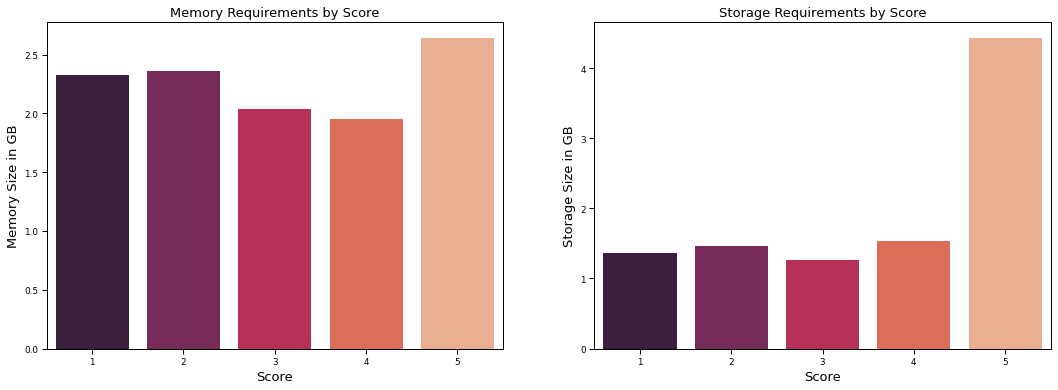

In [481]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
sns.barplot(x=game_info.groupby('avg_score')['memory_size_gb'].mean().index, y=game_info.groupby('avg_score')['memory_size_gb'].mean().values, ax=ax[0], palette='rocket');
sns.barplot(x=game_info.groupby('avg_score')['storage_size_gb'].mean().index, y=game_info.groupby('avg_score')['storage_size_gb'].mean().values, ax=ax[1], palette='rocket');

ax[0].set_title('Memory Requirements by Score', fontsize=13);
ax[1].set_title('Storage Requirements by Score', fontsize=13);
ax[0].set_ylabel('Memory Size in GB', fontsize=13);
ax[1].set_ylabel('Storage Size in GB', fontsize=13);
ax[0].set_xlabel('Score', fontsize=13);
ax[1].set_xlabel('Score', fontsize=13);

In [482]:
game_info.drop(columns=['memory', 'storage', 'memory_size_gb', 'storage_size_gb'], inplace=True)

>Observations:
- There is not much variance in memory size requirement among games. 
- Only tier 1 shows significant storage size difference from other tiers. 
- Drop these features

#### Controller

In [483]:
game_info['controller'].value_counts()

0.000    9837
1.000    8530
Name: controller, dtype: int64

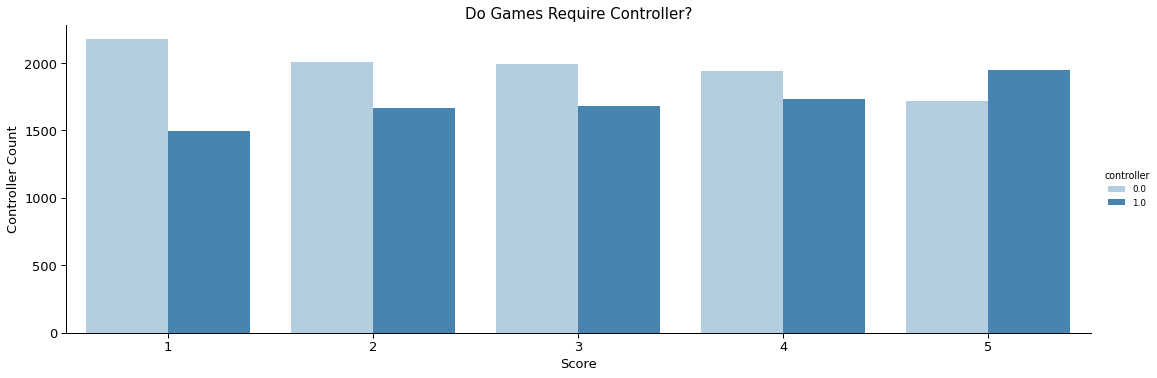

In [484]:
sns.catplot(x="avg_score", kind="count", palette="Blues", hue='controller', data=game_info, aspect=3);
plt.title(f'Do Games Require Controller?', fontsize=15);
plt.ylabel('Controller Count', fontsize=13);
plt.xlabel('Score', fontsize=13);
plt.yticks(fontsize=13);
plt.xticks(fontsize=13);

>Observations:
- Whether games requires a controller is fairly consistent across all the different game tiers. 

### Target Audience

In [485]:
target_audience

['languages', 'tags', 'categories', 'genres', 'required_age']

#### Languages

In [486]:
game_info['language_count'] = game_info['languages'].apply(lambda x: len(x.split()))

In [487]:
game_info['lang_clean'] = game_info['languages'].apply(lambda x: x.lower().split(', '))

In [488]:
unique_lang = []
for i in game_info['lang_clean']:
    unique_lang.extend(i)
unique_lang = set(unique_lang)

In [489]:
# one hot encode languages
for lang in unique_lang:
    game_info['lang_' + lang] = game_info['lang_clean'].map(lambda x: 1 if lang in x else 0)

In [490]:
game_info[['lang_dutch','lang_hungarian', 'lang_korean', 'lang_czech', 'lang_slovakian',
       'lang_french', 'lang_italian', 'lang_english', 'lang_norwegian',
       'lang_arabic', 'lang_german', 'lang_bulgarian', 'lang_turkish',
       'lang_thai', 'lang_russian', 'lang_romanian', 'lang_ukrainian',
       'lang_polish', 'lang_greek', 'lang_vietnamese', 'lang_japanese',
       'lang_danish', 'lang_finnish', 'lang_swedish', 'lang_portuguese']].describe()

,lang_dutch,lang_hungarian,lang_korean,lang_czech,lang_slovakian,lang_french,lang_italian,lang_english,lang_norwegian,lang_arabic,lang_german,lang_bulgarian,lang_turkish,lang_thai,lang_russian,lang_romanian,lang_ukrainian,lang_polish,lang_greek,lang_vietnamese,lang_japanese,lang_danish,lang_finnish,lang_swedish,lang_portuguese
count,18367.000,18367.000,18367.000,18367.000,18367.000,18367.000,18367.000,18367.000,18367.000,18367.000,18367.000,18367.000,18367.000,18367.000,18367.000,18367.000,18367.000,18367.000,18367.000,18367.000,18367.000,18367.000,18367.000,18367.000,18367.000
mean,0.059,0.037,0.102,0.047,0.000,0.278,0.200,1.000,0.026,0.023,0.300,0.018,0.058,0.023,0.262,0.022,0.033,0.108,0.022,0.007,0.164,0.029,0.027,0.039,0.072
std,0.236,0.188,0.303,0.213,0.007,0.448,0.400,0.000,0.160,0.149,0.458,0.135,0.233,0.151,0.439,0.148,0.180,0.311,0.146,0.085,0.370,0.167,0.161,0.193,0.259
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


- We don't need all 25 languages in our analysis, let's remove minority languages < 15%

In [491]:
game_info.drop(columns=['lang_portuguese', 'lang_swedish', 'lang_finnish', 'lang_danish', 'lang_vietnamese', 
                        'lang_greek', 'lang_polish', 'lang_ukrainian', 'lang_romanian', 'lang_thai', 'lang_turkish', 
                        'lang_bulgarian', 'lang_arabic', 'lang_norwegian', 'lang_slovakian', 'lang_czech', 
                        'lang_korean', 'lang_hungarian', 'lang_dutch'], inplace=True)

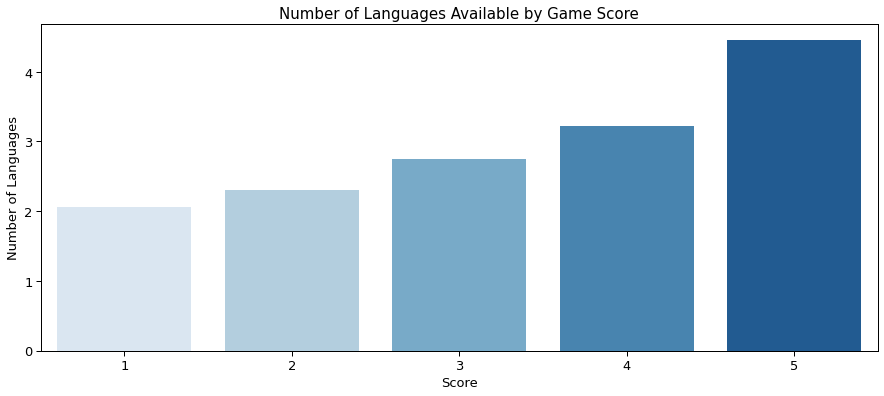

In [492]:
plt.figure(figsize=(15,6))
sns.barplot(x=game_info.groupby('avg_score')['language_count'].mean().index, y=game_info.groupby('avg_score')['language_count'].mean().values, palette="Blues");
plt.title(f'Number of Languages Available by Game Score', fontsize=15);
plt.ylabel('Number of Languages', fontsize=13);
plt.xlabel('Score', fontsize=13);
plt.yticks(fontsize=13);
plt.xticks(fontsize=13);

>Observations:
- Games ranked top on leader board is observed to have more language options as compared to lower ranked games. This makes sense as more languages are available, the player footprint is then no longer restricted to a certain region in the world. 

#### Genres

In [493]:
game_info['genres'] = game_info['genres'].apply(lambda x: x.lower().replace("-", '').replace(' ', '').replace(';', ','))

In [494]:
game_info['genres_clean'] = game_info['genres'].apply(lambda x: x.split(','))

In [495]:
to_remove = ['indie', 'freetoplay']
game_info['genres_clean'] = game_info['genres_clean'].apply(lambda x: [i for i in x if i not in to_remove])

In [496]:
unique_genres = []
for i in game_info['genres_clean']:
    unique_genres.extend(i)
unique_genres = set(unique_genres)

In [497]:
genre_df = game_info[['name_clean','genres_clean']]

In [498]:
for genre in unique_genres:
    genre_df['gr_' + genre] = genre_df['genres_clean'].map(lambda x: 1 if genre in x else 0)

<ipython-input-498-9d95300fb82d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_df['gr_' + genre] = genre_df['genres_clean'].map(lambda x: 1 if genre in x else 0)


In [499]:
top_genres = genre_df.mean().sort_values(ascending=False)[:10]*18367

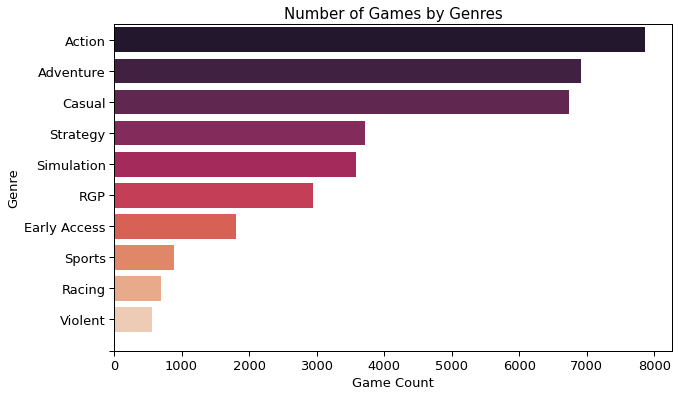

In [500]:
plt.figure(figsize=(10,6))
sns.barplot(x=top_genres.values, y=top_genres.index, palette='rocket');
plt.title(f'Number of Games by Genres', fontsize=15);
plt.ylabel('Genre',fontsize=13);
plt.xlabel('Game Count', fontsize=13);
plt.yticks(np.arange(11), ['Action','Adventure','Casual','Strategy','Simulation','RGP','Early Access','Sports','Racing','Violent'], fontsize=13);
plt.xticks(fontsize=13);

In [501]:
top_20_games = game_info[:20]['name_clean'].values

In [502]:
top_20_games_genres = genre_df[genre_df['name_clean'].isin(top_20_games)].mean().sort_values(ascending=False)*20

In [503]:
top_20_games_genres = top_20_games_genres[top_20_games_genres>0]

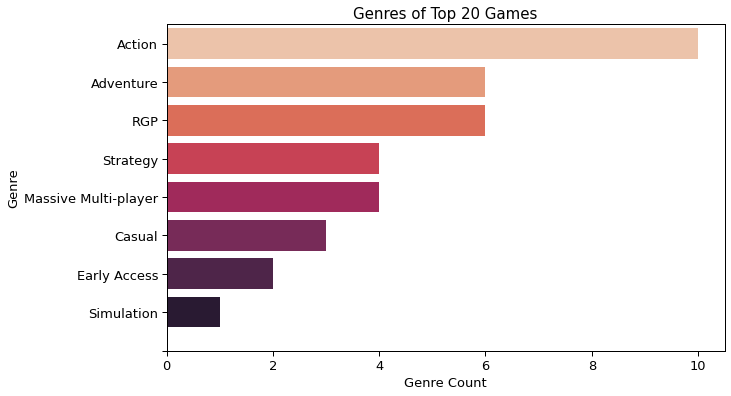

In [504]:
plt.figure(figsize=(10,6))
sns.barplot(x=top_20_games_genres.values, y=top_20_games_genres.index, palette='rocket_r');
plt.title(f'Genres of Top 20 Games', fontsize=15);
plt.ylabel('Genre',fontsize=13);
plt.xlabel('Genre Count', fontsize=13);
plt.yticks(np.arange(9), ['Action','Adventure','RGP','Strategy','Massive Multi-player','Casual','Early Access','Simulation'], fontsize=13);
plt.xticks(fontsize=13);

In [505]:
def collect_pairs(lines):
    pair_counter = Counter()
    for line in lines:
        # exclude duplicates in same line and sort to ensure one word is always before other
        unique_tokens = sorted(set(line))  
        combos = combinations(unique_tokens, 2)
        pair_counter += Counter(combos)
    return pair_counter

In [506]:
genre_pairs = collect_pairs(game_info['genres_clean'])

In [507]:
sorted_dictionary = {}
# sort the keys in descending orders
sorted_keys = sorted(genre_pairs, key=genre_pairs.get, reverse=True)
for key in sorted_keys:
    sorted_dictionary[key] = genre_pairs[key]

In [508]:
sorted_dictionary

{('action', 'adventure'): 2948,
 ('adventure', 'casual'): 2421,
 ('action', 'casual'): 2062,
 ('adventure', 'rpg'): 1656,
 ('casual', 'simulation'): 1448,
 ('casual', 'strategy'): 1269,
 ('action', 'rpg'): 1200,
 ('simulation', 'strategy'): 1164,
 ('action', 'simulation'): 1044,
 ('action', 'earlyaccess'): 1033,
 ('action', 'strategy'): 1017,
 ('adventure', 'simulation'): 916,
 ('adventure', 'strategy'): 808,
 ('rpg', 'strategy'): 794,
 ('adventure', 'earlyaccess'): 610,
 ('earlyaccess', 'simulation'): 591,
 ('casual', 'rpg'): 587,
 ('earlyaccess', 'strategy'): 480,
 ('casual', 'earlyaccess'): 476,
 ('simulation', 'sports'): 457,
 ('rpg', 'simulation'): 451,
 ('earlyaccess', 'rpg'): 406,
 ('action', 'violent'): 400,
 ('casual', 'sports'): 357,
 ('action', 'sports'): 346,
 ('action', 'racing'): 329,
 ('gore', 'violent'): 295,
 ('action', 'massivelymultiplayer'): 281,
 ('adventure', 'violent'): 261,
 ('action', 'gore'): 253,
 ('racing', 'simulation'): 238,
 ('racing', 'sports'): 238,
 ('

- **We will not use genre pairs with more than 5000 appearance to maintain uniqueness of games.**
- **We will not use genre pairs with less than 400  appearance since these games are too rare.**

In [509]:
game_info['gr_act_adv'] = game_info['genres_clean'].apply(lambda x: 1 if ('action' in x) & ('adventure' in x) else 0)

In [510]:
game_info['gr_act_cas'] = game_info['genres_clean'].apply(lambda x: 1 if ('action' in x) & ('casual' in x) else 0)

In [511]:
game_info['gr_act_rpg'] = game_info['genres_clean'].apply(lambda x: 1 if ('action' in x) & ('rpg' in x) else 0)

In [512]:
game_info['gr_stg_cas'] = game_info['genres_clean'].apply(lambda x: 1 if ('strategy' in x) & ('casual' in x) else 0)

In [513]:
game_info['gr_sim_cas'] = game_info['genres_clean'].apply(lambda x: 1 if ('simulation' in x) & ('casual' in x) else 0)

In [514]:
game_info['gr_adv_cas'] = game_info['genres_clean'].apply(lambda x: 1 if ('adventure' in x) & ('casual' in x) else 0)

In [515]:
game_info['gr_adv_ea'] = game_info['genres_clean'].apply(lambda x: 1 if ('adventure' in x) & ('earlyaccess' in x) else 0)

In [516]:
game_info['gr_adv_rpg'] = game_info['genres_clean'].apply(lambda x: 1 if ('adventure' in x) & ('rpg' in x) else 0)

In [517]:
game_info['gr_strategy'] = game_info['genres_clean'].apply(lambda x: 1 if ('strategy' in x) else 0)

In [518]:
game_info['gr_simulation'] = game_info['genres_clean'].apply(lambda x: 1 if ('simulation' in x) else 0)

In [519]:
game_info['gr_earlyaccess'] = game_info['genres_clean'].apply(lambda x: 1 if ('earlyaccess' in x) else 0)

In [520]:
game_info['gr_sports'] = game_info['genres_clean'].apply(lambda x: 1 if ('sports' in x) else 0)

In [521]:
game_info['gr_racing'] = game_info['genres_clean'].apply(lambda x: 1 if ('racing' in x) else 0)

In [522]:
game_info['gr_rpg'] = game_info['genres_clean'].apply(lambda x: 1 if ('rpg' in x) else 0)

In [523]:
game_info['gr_mmp'] = game_info['genres_clean'].apply(lambda x: 1 if ('massivelymultiplayer' in x) else 0)

> Feature Engineering:
- Since the top genres are occurring too often, we are keeping only the less frequent main genres
    - strategy, early access, sports, racing, rpg and massive multi-players
- Combination of frequently co-occurred genres are included as sub-genres to differentiate games.
    - two sub-genres from each main category are chosen

#### Tags and Categories

In [524]:
game_info['categ_clean'] = game_info['categories'].apply(lambda x: x.lower().replace("-", '').replace(' ', '').replace(';', ',').split(','))

In [525]:
unique_categories = []
for i in game_info['categ_clean']:
    unique_categories.extend(i)
unique_categories = set(unique_categories)

In [526]:
len(unique_categories)

29

In [527]:
category_pairs = collect_pairs(game_info['categ_clean'])

In [528]:
sorted_dictionary2 = {}
# sort the keys in descending orders
sorted_keys = sorted(category_pairs, key=category_pairs.get, reverse=True)
for key in sorted_keys:
    sorted_dictionary2[key] = category_pairs[key]

In [529]:
sorted_dictionary2
# we will use categories with less than 5000 appearance

{('singleplayer', 'steamachievements'): 10031,
 ('singleplayer', 'steamtradingcards'): 6016,
 ('singleplayer', 'steamcloud'): 5300,
 ('steamachievements', 'steamtradingcards'): 5005,
 ('steamachievements', 'steamcloud'): 4651,
 ('fullcontrollersupport', 'singleplayer'): 4030,
 ('fullcontrollersupport', 'steamachievements'): 3363,
 ('steamcloud', 'steamtradingcards'): 2989,
 ('partialcontrollersupport', 'singleplayer'): 2768,
 ('singleplayer', 'steamleaderboards'): 2495,
 ('steamachievements', 'steamleaderboards'): 2362,
 ('multiplayer', 'singleplayer'): 2320,
 ('fullcontrollersupport', 'steamtradingcards'): 2154,
 ('fullcontrollersupport', 'steamcloud'): 2120,
 ('partialcontrollersupport', 'steamachievements'): 1818,
 ('multiplayer', 'steamachievements'): 1573,
 ('steamcloud', 'steamleaderboards'): 1385,
 ('shared/splitscreen', 'singleplayer'): 1375,
 ('stats', 'steamachievements'): 1288,
 ('steamleaderboards', 'steamtradingcards'): 1277,
 ('singleplayer', 'stats'): 1274,
 ('multiplaye

In [530]:
game_info['cat_ach_cloud'] = game_info['categ_clean'].apply(lambda x: 1 if ('steamachievements' in x) & ('steamcloud' in x) else 0)

In [531]:
game_info['cat_ctl_sp'] = game_info['categ_clean'].apply(lambda x: 1 if ('fullcontrollersupport' in x) & ('singleplayer' in x) else 0)

In [532]:
game_info['cat_ctl_ach'] = game_info['categ_clean'].apply(lambda x: 1 if ('steamachievements' in x) & ('fullcontrollersupport' in x) else 0)

In [533]:
game_info['cat_pctl_sp'] = game_info['categ_clean'].apply(lambda x: 1 if ('partialcontrollersupport' in x) & ('singleplayer' in x) else 0)

In [534]:
game_info['cat_sp_leader'] = game_info['categ_clean'].apply(lambda x: 1 if ('singleplayer' in x) & ('steamleaderboards' in x) else 0)

In [535]:
game_info['cat_ach_leader'] = game_info['categ_clean'].apply(lambda x: 1 if ('steamachievements' in x) & ('steamleaderboards' in x) else 0)

In [536]:
game_info['cat_sp_mp'] = game_info['categ_clean'].apply(lambda x: 1 if ('multiplayer' in x) & ('singleplayer' in x) else 0)

In [537]:
game_info['cat_ctl_cloud'] = game_info['categ_clean'].apply(lambda x: 1 if ('fullcontrollersupport' in x) & ('steamcloud' in x) else 0)

In [538]:
game_info['cat_pctl_ach'] = game_info['categ_clean'].apply(lambda x: 1 if ('partialcontrollersupport' in x) & ('steamachievements' in x) else 0)

In [539]:
game_info['cat_mp_ach'] = game_info['categ_clean'].apply(lambda x: 1 if ('multiplayer' in x) & ('steamachievements' in x) else 0)

In [540]:
game_info['cat_mp_coop'] = game_info['categ_clean'].apply(lambda x: 1 if ('multiplayer' in x) & ('coop' in x) else 0)

In [541]:
game_info['cat_singleplayer'] = game_info['categ_clean'].apply(lambda x: 1 if ('singleplayer' in x) else 0)

In [542]:
game_info['cat_multiplayer'] = game_info['categ_clean'].apply(lambda x: 1 if ('multiplayer' in x) else 0)

In [543]:
game_info['cat_steamtradingcards'] = game_info['categ_clean'].apply(lambda x: 1 if ('steamtradingcards' in x) else 0)

In [544]:
game_info['cat_steamleaderboards'] = game_info['categ_clean'].apply(lambda x: 1 if ('steamleaderboards' in x) else 0)

> Feature Engineering:
- Since there are too many different categories, we are keeping the four basic categories:
    - single player, multi-player, steam trading cards, steam leader boards
- Combination of frequently co-occurrence categories are included as subcategories to differentiate games.
    - two subcategories from each main category are chosen

In [545]:
game_info['tags_clean'] = game_info['tags'].apply(lambda x: x.lower().replace('-', '').replace(' ', '').split(","))

In [546]:
unique_tags = []
for i in game_info['tags_clean']:
    unique_tags.extend(i)
unique_tags = set(unique_tags)

In [547]:
len(unique_tags)

419

In [548]:
tags_df = game_info[['tags_clean']]

In [549]:
for tag in unique_tags:
    tags_df['tag_' + tag] = tags_df['tags_clean'].map(lambda x: 1 if tag in x else 0)

<ipython-input-549-3d66c7da45bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tags_df['tag_' + tag] = tags_df['tags_clean'].map(lambda x: 1 if tag in x else 0)


In [550]:
tags_df.mean()[tags_df.mean()>0.15]

tag_2d             0.168
tag_indie          0.758
tag_rpg            0.177
tag_action         0.463
tag_casual         0.419
tag_strategy       0.232
tag_adventure      0.430
tag_puzzle         0.151
tag_singleplayer   0.328
tag_simulation     0.224
dtype: float64

- Notice that it overlaps with genre feature. Therefore, we will drop this.

In [551]:
game_info.drop(columns=['tags_clean'], inplace=True)

#### Required Age

In [552]:
game_info[game_info['required_age']>0].groupby('avg_score')['required_age'].describe()

,count,mean,std,min,25%,50%,75%,max
avg_score,,,,,,,,
1,30.000,15.800,2.483,12.000,13.000,16.000,18.000,18.000
2,31.000,15.645,3.352,3.000,14.000,16.000,18.000,18.000
3,41.000,15.268,4.105,3.000,16.000,16.000,18.000,18.000
4,65.000,16.323,2.258,7.000,16.000,16.000,18.000,18.000
5,207.000,16.700,2.352,3.000,16.000,18.000,18.000,18.000


In [553]:
game_info.drop(columns=['required_age'], inplace=True)

>Observations:
- It is observed that age requirement is similar for games with different ratings, with exception of score 1 games. The minimum age requirement is 12 years. 
- Since there is no clear relationship between age requirement and game score, we will not consider this feature in our analysis. 

## User Information

In [554]:
user_info.head()

,userid,name,behavior,hrs_played
0,151603712,The Elder Scrolls V Skyrim,play,273.000
1,151603712,Fallout 4,purchase,1.000
2,151603712,Fallout 4,play,87.000
3,151603712,Spore,purchase,1.000
4,151603712,Spore,play,14.900


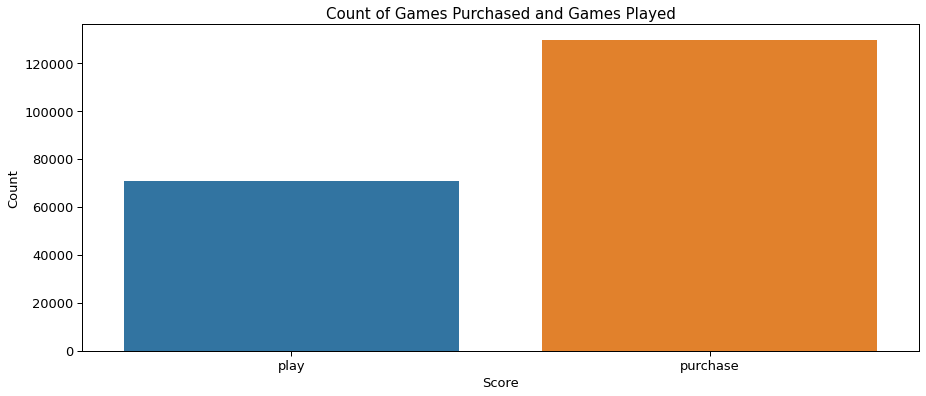

In [555]:
plt.figure(figsize=(15,6))
sns.countplot(x='behavior', data=user_info);
plt.title(f'Count of Games Purchased and Games Played', fontsize=15);
plt.ylabel('Count', fontsize=13);
plt.xlabel('Score', fontsize=13);
plt.yticks(fontsize=13);
plt.xticks(fontsize=13);

>Observations:
- It is observed that there are more games purchased than games being played. 
- This could possibly mean the games purchase do not match player preference, therefore, players are not playing them. 

In [556]:
user_info = user_info[user_info['behavior']=='play']

In [557]:
user_info['name_clean'] = user_info['name'].apply(lambda x: re.sub('\W+', ' ', x))

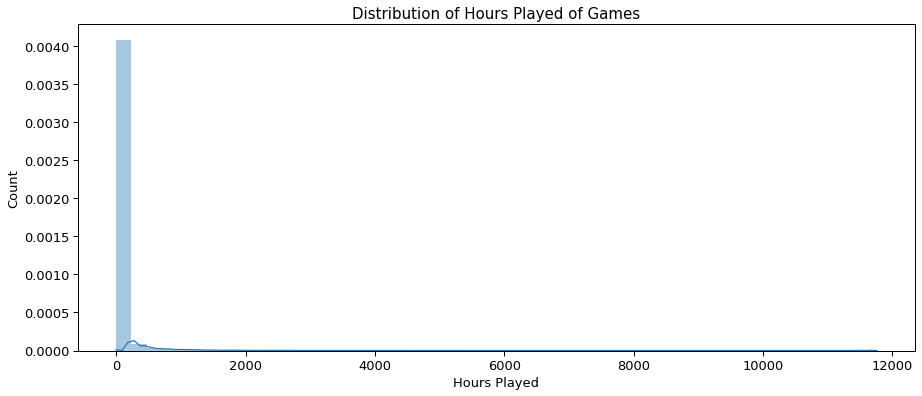

In [558]:
plt.figure(figsize=(15,6))
sns.distplot(user_info['hrs_played']);
plt.title(f'Distribution of Hours Played of Games', fontsize=15);
plt.ylabel('Count', fontsize=13);
plt.xlabel('Hours Played', fontsize=13);
plt.yticks(fontsize=13);
plt.xticks(fontsize=13);

In [559]:
user_playtime = user_info.groupby('userid').sum()['hrs_played'].sort_values(ascending=False)[:10]

In [560]:
user_playtime

userid
73017395    11754.000
10599862    11651.700
100630947   10853.200
26762388    10470.100
153382649    9640.000
43684632     9546.300
48798067     9427.200
52731290     9417.600
42935819     8172.900
14544587     8137.100
Name: hrs_played, dtype: float64

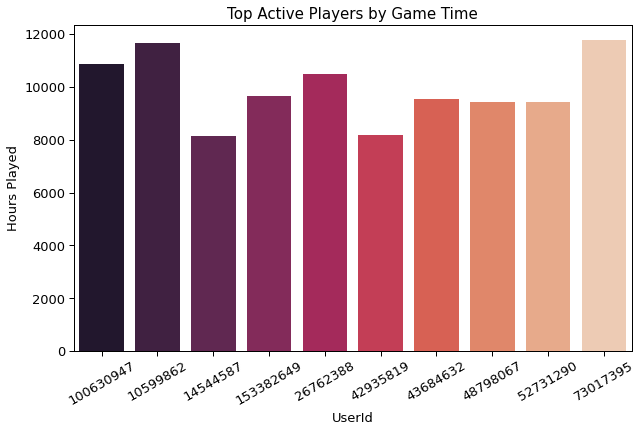

In [561]:
plt.figure(figsize=(10,6))
sns.barplot(y=user_playtime.values, x=['73017395','10599862','100630947','26762388','153382649','43684632',
                                       '48798067','52731290','42935819','14544587'], palette='rocket');
plt.title(f'Top Active Players by Game Time', fontsize=15);
plt.ylabel('Hours Played',fontsize=13);
plt.xlabel('UserId', fontsize=13);
plt.yticks(fontsize=13);
plt.xticks(rotation=30, fontsize=13);

>Observations:
- Distribution of hours played is severely right skewed. 
- Upon closer look, we can see that Dota 2 and counter strike are examples of popular games favored by players. 
- Some players were addicted to it and played for more than 4000 hours.
- To normalize distribution of play time, let's log the hours played. 

In [562]:
user_info['user_score'] = np.log(user_info['hrs_played'])

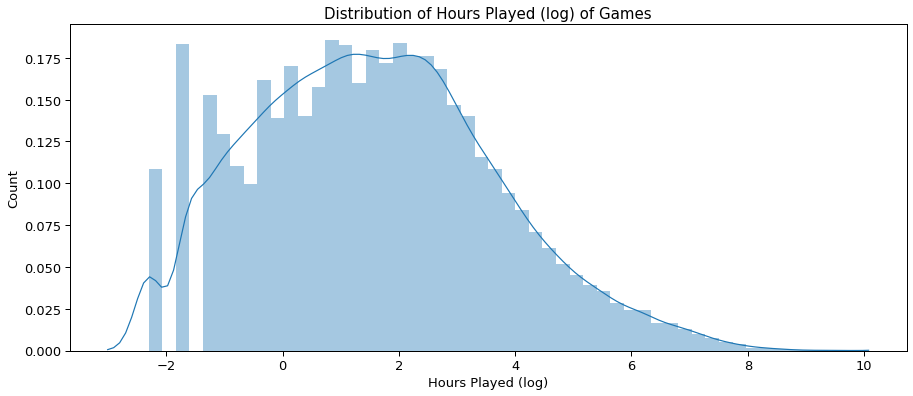

In [563]:
plt.figure(figsize=(15,6))
sns.distplot(user_info['user_score']);
plt.title(f'Distribution of Hours Played (log) of Games', fontsize=15);
plt.ylabel('Count', fontsize=13);
plt.xlabel('Hours Played (log)', fontsize=13);
plt.yticks(fontsize=13);
plt.xticks(fontsize=13);

In [564]:
user_info['user_score'].describe()

count   70489.000
mean        1.589
std         2.068
min        -2.303
25%         0.000
50%         1.504
75%         2.950
max         9.372
Name: user_score, dtype: float64

In [565]:
user_info['user_score'] = user_info['user_score'].apply(lambda x: ((x+2.303)/(9.372+2.303))*5)

- Since there is no user score in the user data, we will use hours played as proxy for game score. 

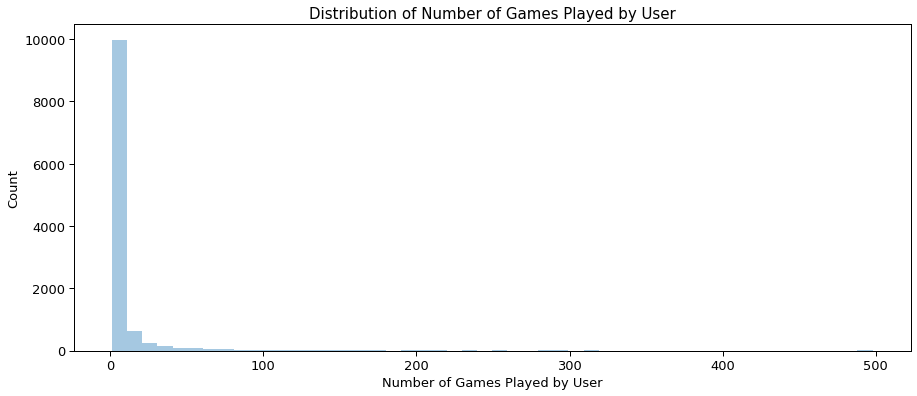

In [566]:
plt.figure(figsize=(15,6))
sns.distplot(user_info.groupby('userid').count()['name'].sort_values(ascending=False), kde=False);
plt.title(f'Distribution of Number of Games Played by User', fontsize=15);
plt.ylabel('Count', fontsize=13);
plt.xlabel('Number of Games Played by User', fontsize=13);
plt.yticks(fontsize=13);
plt.xticks(fontsize=13);

In [567]:
active_users = list(user_info.groupby('userid').count()['name'].sort_values(ascending=False)[:1].index)

In [568]:
user_info[user_info['userid'].isin(active_users)]

,userid,name,behavior,hrs_played,name_clean,user_score
119916,62990992,Counter-Strike Global Offensive,play,663.000,Counter Strike Global Offensive,3.769
119918,62990992,Sid Meier's Civilization V,play,550.000,Sid Meier s Civilization V,3.689
119920,62990992,Total War SHOGUN 2,play,212.000,Total War SHOGUN 2,3.280
119922,62990992,Total War ROME II - Emperor Edition,play,198.000,Total War ROME II Emperor Edition,3.251
119924,62990992,Dungeon Defenders,play,195.000,Dungeon Defenders,3.245
...,...,...,...,...,...,...
120902,62990992,Crysis Wars,play,0.100,Crysis Wars,0.000
120904,62990992,Crysis 2 Maximum Edition,play,0.100,Crysis 2 Maximum Edition,0.000
120906,62990992,Crysis,play,0.100,Crysis,0.000
120908,62990992,Company of Heroes (New Steam Version),play,0.100,Company of Heroes New Steam Version,0.000


>Observations:
- It is observed that majority of users played less than 50 games and some very active users played close to 500 games. 
- The most active user played 498 games and his favorite game is counter strike which he played for approximately 650 hours. 

In [569]:
game_info.to_csv('../Dataset/game_info.csv', index=False)

In [570]:
user_info.to_csv('../Dataset/user_info.csv', index=False)

In [571]:
combined = pd.merge(game_info, user_info, on='name_clean')

In [572]:
combined.to_csv('../Dataset/combined.csv', index=False)

In [573]:
game_info['name'].nunique()

18367

In [574]:
user_info['userid'].nunique()

11350